In [14]:
# Usage guide:

# This document is not kept on record. If the calcualtions are to be kept,
# copy the whole notebook and put it in "quick_calculations" or appropriate
# folders.

In [15]:
# import all the E9 stuff
import logging
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import time

# User defined modules
E9path = Path("C:/", "Users", "ken92", "Documents", "Studies", "E5", "simulation", "E9_simulations")
if str(E9path) not in sys.path:
    sys.path.insert(1, str(E9path))
import E9_fn.E9_constants as E9c
import E9_fn.E9_atom as E9a
import E9_fn.E9_cooltrap as E9ct
import E9_fn.plane_wave_expansion.blochstate_class as bsc
# import E9_fn.polarizabilities_calculation as E9pol
# import E9_fn.datasets.transition_line_data as TLData
from E9_fn import util

# Logging
logpath = '' # '' if not logging to a file
loglevel = logging.INFO
logroot = logging.getLogger()
list(map(logroot.removeHandler, logroot.handlers))
list(map(logroot.removeFilter, logroot.filters))
logging.basicConfig(filename = logpath, level = loglevel)

# Inputs

In [38]:
species = "Rb87" # "Rb87", "K40"

# lattice parameters
V532nom = 25            # in kHz (i.e. V_SI / hbar / 1e3 / 2pi)
V1064nom = 15           # Note that setting this to 0 doesn't give you a proper band structure of 532 nm lattice, since you are now
                        # considering too many plane waves that don't actually contribute.
n0nom = 0               # peak density
# The superlattice phase that determines the relative position between 1064 and 532 lattice
# 532 lattice is fixed at 0, so changing the pase by pi for 1064 restores the original lattice
phi12, phi23 = 0., 0.
# phi12, phi23 = np.pi*2/3, -np.pi*2/3    # decorated triangular lattice
ABoffset1064nom = 0     # max 0.011585 * V1064nom / 9 / np.sqrt(3) for Rb
B1_rel_int_1064 = 1     # relative intensity (field is sqrt of that) of 1064 B1
B1_rel_int_532  = 0.6     # relative intensity (field is sqrt of that) of 532 B1
B3_rel_int_1064 = 1     # relative intensity (field is sqrt of that) of 1064 B3
B3_rel_int_532  = 1     # relative intensity (field is sqrt of that) of 532 B3

# Basic simulation parameters
num = 6             # size of q-momentum space we consider: (-num, num) (usually 5)
k_center = (0, 0)
bandstart = 0       # starting from 0, inclusive
bandend = 5         # inclusive
Qp_str = '(Kp/K + 0.4 * np.array([np.cos(pi/3), np.sin(pi/3)]))'
qverts_str = 'E9c.Kp4/E9c.k_lw, E9c.Gp/E9c.k_lw, E9c.Kp/E9c.k_lw, E9c.Mp/E9c.k_lw, E9c.Gp/E9c.k_lw'
# qverts_str = 'E9c.Kp/E9c.k_lw, E9c.Kp2/E9c.k_lw, E9c.Kp3/E9c.k_lw, E9c.Kp4/E9c.k_lw, E9c.Kp5/E9c.k_lw, E9c.Kp6/E9c.k_lw, E9c.Kp/E9c.k_lw'
x_ticklist = ["K'", '$\Gamma$', 'K', 'M', '$\Gamma$']
qverts_type = 1     # "What qset defines": 1 - line; 2 - area (see PlotBZSubplot)
save_results = False

# Initialization
## Units

In [39]:
if species == "Rb87":
    all_units_dict = E9c.all_lat_unit_Rb87
elif species == "K40":
    all_units_dict = E9c.all_lat_unit_K40
else:
    raise ValueError("Unknown species: {}".format(species))
m_unit = all_units_dict["m_unit"]
l_unit = all_units_dict["l_unit"]
E_unit = all_units_dict["E_unit"]
f_unit = all_units_dict["f_unit"]
t_unit = all_units_dict["t_unit"]

V532 = 2 * np.pi * V532nom * 1e3 / f_unit   # 2 * np.pi because I have f = E/hbar instead of E/h as normally defined
V1064 = 2 * np.pi * V1064nom * 1e3 / f_unit
ABoffset1064 = 2 * np.pi * ABoffset1064nom * 1e3 / f_unit
n0 = n0nom * l_unit**3

In [40]:
Exp_lib = {"species": species, "units_dict": all_units_dict
        , 'V532nom': V532nom, 'V1064nom': V1064nom, 'V532': V532, 'V1064': V1064
        , 'B1_rel_int_532': B1_rel_int_532, 'B1_rel_int_1064': B1_rel_int_1064 , 'B3_rel_int_532': B3_rel_int_532, 'B3_rel_int_1064': B3_rel_int_1064
        , 'n0nom': n0nom, 'n0': n0
        , 'ABoffset1064nom': ABoffset1064nom, 'ABoffset1064': ABoffset1064
        , 'phi12': phi12, 'phi23': phi23}

size = 2 * num + 1
bandnum = bandend - bandstart + 1 # number of bands interested in
qverts_arr = eval(qverts_str)

In [41]:
def MinimumGap(e_values, band1, band2):
    """Prints the position and energy of the minimum gap.
    
    Example: MinimumGap(e_values,2,3)
    Should be slightly enhanced to return something
    """
    gaps = e_values[:, band2] - e_values[:, band1]
    print('The minimum band gap between band{} and band{} is {} kHz, happening at the {} (python index) q evaluated' \
          .format(band1, band2, gaps.min() * f_unit / 1e3 / (2 * np.pi), gaps.argmin()))

def find_q_geo_tensor(n_q, n_band, Exp_lib, q_list, E_list, psi_list, Hq_mmat, Hq_nmat, component = 'xx'):
    """Find the quantum geometric tensor for a given Bloch state psi."""
    q = q_list[n_q]
    psin = psi_list[n_q, :, n_band]
    En = E_list[n_q, n_band]
    dH1 = bsc.find_del_H(q, Exp_lib, Hq_mmat, Hq_nmat, direction = component[0])
    dH2 = bsc.find_del_H(q, Exp_lib, Hq_mmat, Hq_nmat, direction = component[1])
    qgt = 0j
    for m_band in range(E_list.shape[1]):
        if m_band == n_band:
            continue
        psim = psi_list[n_q, :, m_band]
        Em = E_list[n_q, m_band]
        qgt += psim.conj() @ dH1 @ psin * psin.conj() @ dH2 @ psim / (Em - En)**2
    if not util.IsHermitian(qgt):
        logging.warning(f"Quantum geometric tensor for n_band {n_band}, n_q {n_q} is not Hermitian")
    return qgt

# Real space plots

In [42]:
bool_plot_real = True
x_real = np.linspace(-1, 1, 500) * 1e-6
y_real = np.linspace(-1.1, 1.1, 500) * 1e-6

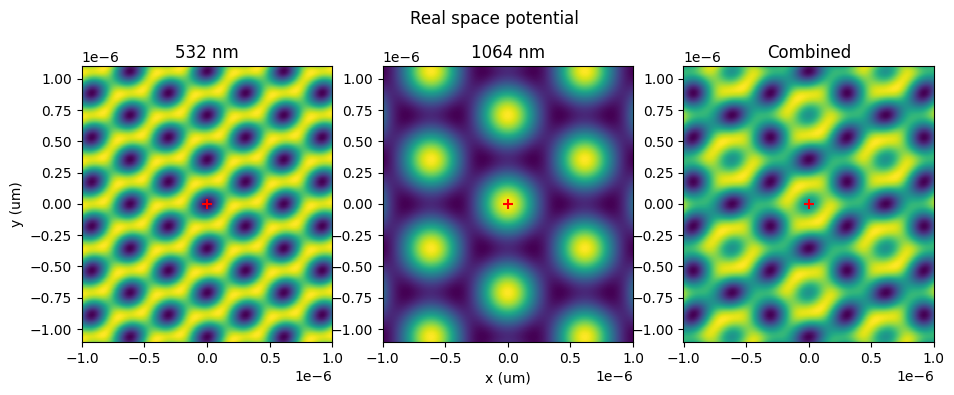

In [43]:
pos_delta = E9c.a_lw_hex * E9c.k1k * (phi12 / 2 / np.pi) + E9c.a_lw_hex * E9c.k3k * (phi23 / 2 / np.pi)
x_delta, y_delta = pos_delta # should be simple functions of phi12 and phi23
V_532_real = bsc.get_Vin(x_real, y_real, V532, B1_rel_int_532, B3_rel_int_532, 0, 0, 1)
V_1064_real = - bsc.get_Vin(x_real, y_real, V1064, B1_rel_int_1064, B3_rel_int_1064, x_delta, y_delta, 2)
V_super_real = V_532_real + V_1064_real
fig_real = plt.figure(figsize = (11, 4))
ax_532 = fig_real.add_subplot(131, aspect = "equal")
ax_1064 = fig_real.add_subplot(132, aspect = "equal")
ax_super = fig_real.add_subplot(133, aspect = "equal")
fig_real.suptitle("Real space potential")
ax_532.set_ylabel("y (um)")
ax_1064.set_xlabel("x (um)")
if bool_plot_real:
    for ax, V_real, ax_title in zip([ax_532, ax_1064, ax_super],
                                    [V_532_real, V_1064_real, V_super_real],
                                    ["532 nm", "1064 nm", "Combined"]):
        im = ax.pcolormesh(x_real, y_real, V_real, cmap = 'viridis')
        ax.scatter(0, 0, color = 'red', marker = '+', s = 50)
        ax.set_title(ax_title)
        # fig_real.colorbar(im, ax = ax)
    

# Finding Bloch states and band energies

Total number of points = 297


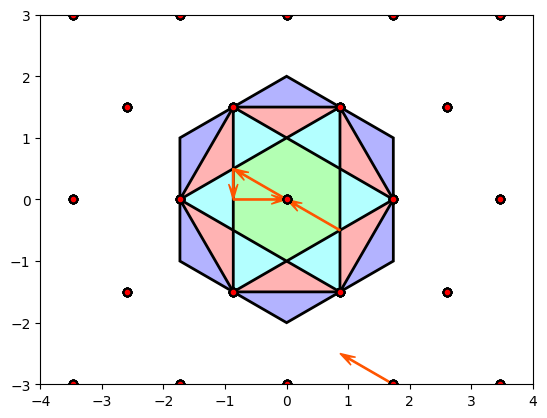

--- 1.5353567600250244 seconds ---


In [44]:
start_time = time.time()

# Generate qset
if qverts_type == 1:
    num_points = np.array([100, 100, 60, 40]) # number of points sampled between two points (can be an array specifying each path, or just one number for all)
    index_points = np.hstack((np.array([0]), np.cumsum(num_points))) - np.arange(len(num_points) + 1)
    qsets = bsc.FindqSets(num_points, qverts_arr)#bsc.FindqSets(points, Gammap/k, kp/k, mp/k, Gammap/k)
    PlotBZinput = qverts_str
elif qverts_type == 2:
    dq = 0.02
    dq2BZfrac = dq**2 * (2/(bandend + 1)) / (np.sqrt(3)/8) # (ONLY CORRECT FOR Kp > Gp > Mp > Kp) how much of a BZ does a point roughly correspond to
    qsets = bsc.FindqArea(qverts_arr, dqx = dq, dqy = dq)
    PlotBZinput = (qverts_str, qsets)

e_values = np.zeros((len(qsets), bandnum), dtype = np.cdouble)
e_states = np.zeros((len(qsets), size**2, bandnum), dtype = np.cdouble)
e_states_ni = [[] for _ in range(bandnum)]

# find non-interacting solution
print("Total number of points = {0}".format(len(qsets)))
ax_BZ = bsc.PlotBZ(qset = PlotBZinput)
xrun = np.arange(len(qsets))
Hq_mmat, Hq_nmat, H_532, H_1064 = bsc.find_H_components(num, Exp_lib, center = k_center)
for i in range(len(qsets)):
    H = bsc.find_H(qsets[i], Exp_lib, Hq_mmat, Hq_nmat, H_532, H_1064)
    e_values[i,:], e_states[i,:,:] = bsc.FindEigenStuff(H, (bandstart, bandend), num = num)
    for j, bandN in enumerate(range(bandstart, bandend + 1)):
        e_states_ni[j].append(bsc.blochstate(e_states[i,:,j], q = qsets[i], center = k_center, N = bandN, E = e_values[i,j], param = Exp_lib))

print("--- {0} seconds ---".format((time.time() - start_time)))

In [45]:
if not np.all(np.isreal(e_values)):
    logging.warning('Complex eigenvalue detected. Imaginary parts are discarded.')
else:
    e_values = e_values.astype(np.double)

if save_results:
    path_str = "simulation_results\\" #IF NOT WORKING: CHANGE TO FULL PATH NAME // TRY ADDING FULL PATH TO "PYTHONPATH manager"
    suffix_str = "_honeycomb_NearG_20210826"
    sim_str = "e_values_ni_{0}_{1}_{2}_k{3}{3}_{4}{5}".format(
                V532nom, V1064nom, n0nom, num, k_center[0], k_center[1])
    bsc.SaveStateList(path_str + sim_str + suffix_str, e_states_ni)

C:\Users\ken92\AppData\Local\Temp\ipykernel_23612\3268161843.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  e_values = e_values.astype(np.double)


# Plots

## Band structure

Text(0.5, 1.0, 'V532 = 25 kHz, V1064 = 15 kHz; AB offset = 0.0 kHz\nn0 = 0; (-6,6)_(0, 0); phi = (0.0,0.0)')

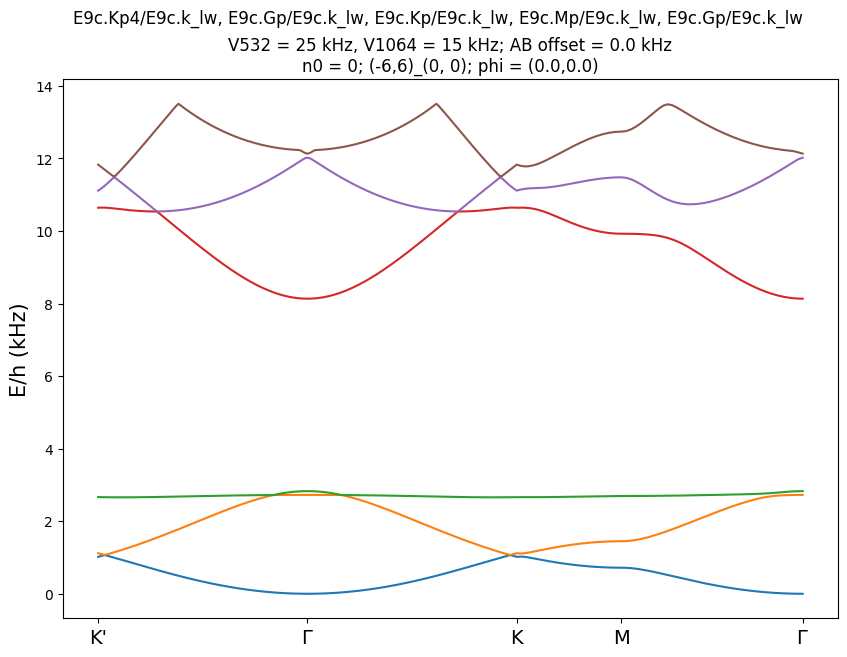

In [46]:
f2kHz = f_unit / 1e3 / (2 * np.pi) # conversion factor from natural units to kHz
E_lowest = np.min(e_values)
E_kHz_offset = (e_values - E_lowest) * f2kHz
E_kHz_highest = np.max(E_kHz_offset)
fig_E = plt.figure(0, figsize=(10,7))
fig_E.clf()
fig_E.suptitle(qverts_str)

if qverts_type == 1:
    ax_E = fig_E.add_subplot(111)
    #xq = [np.linalg.norm(qpt) for qpt in qsets] # won't work for plots with winding q paths
    xq = bsc.FindQAxis(num_points, qverts_arr)
    ax_E.set_ylabel('E/h (kHz)', fontsize = 15)
    for i in range(bandnum):
        ax_E.plot(xq, (e_values.transpose()[i] - E_lowest) * f2kHz, '-', label = 'Non-interacting' + str(i + bandstart))
    plt.xticks(xq[index_points], x_ticklist, fontsize = 14) # why does ax.set_xticks not work?
elif qverts_type == 2:
    ax_E = fig_E.add_subplot(111, projection = '3d')
    # Add BZ boundary
    bz1qx, bz1qy = [q[0] for q in E9c.BZ1_vertices], [q[1] for q in E9c.BZ1_vertices]
    for i in range(3):
        ax_E.plot(bz1qx, bz1qy, np.ones_like(bz1qx) * E_kHz_highest * i / 2, '-k', alpha = 0.5)
    for i in range(bandnum):
        ax_E.plot_trisurf(qsets[:, 0], qsets[:, 1], E_kHz_offset[:, i]) # TODO: try plotly
    ax_E.set_xlabel('q_x', fontsize = 15)
    ax_E.set_ylabel('q_y', fontsize = 15)
    ax_E.set_zlabel('E/h (kHz)', fontsize = 15)

ax_E.set_title('V532 = {} kHz, V1064 = {} kHz; AB offset = {:.4} kHz\nn0 = {}; (-{},{})_{}; phi = ({:.4},{:.4})'.format(V532nom, V1064nom, float(ABoffset1064nom), n0nom, num, num, k_center, phi12, phi23))

## Quantum metric tensor

In [47]:
bool_find_QMT = False

In [48]:
if bool_find_QMT:
    qgts_xx = np.zeros((len(qsets), bandnum), dtype = np.cdouble)
    for i in range(len(qsets)):
        for j in range(bandnum):
            qgts_xx[i, j] = find_q_geo_tensor(i, j, Exp_lib, qsets, e_values, e_states, Hq_mmat, Hq_nmat)
    qmts_xx = np.real(qgts_xx)                # quantum metric tensor
    berry_curvs_xx = - 2 * np.imag(qgts_xx)   # Berry curvature

    fig_qgt = plt.figure(2, figsize=(10,7))
    fig_qgt.clf()
    ax_qgt = fig_qgt.add_subplot(111)
    ax_qgt.set_title('Quantum geometric tensor')
    ax_qgt.plot(xq, qmts_xx[:, 2], label = 'qmts_00')